# NanoSchnack Model

## Setup Devices

- Verify that MPS is available (for Apple Silicon GPUs).

In [1]:
import contextlib
import os
import torch
from dataclasses import dataclass

# Avoid tokenizers fork warnings in worker processes.
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

from device import device_info, pick_device, print_ddp_info, print_device_info, print_sdpa_info

# Setup distributed data parallel (DDP)
ddp_rank = int(os.getenv("RANK", "0"))
ddp_world_size = int(os.getenv("WORLD_SIZE", "1"))
ddp_local_rank_env = os.getenv("LOCAL_RANK")
ddp_local_rank = int(ddp_local_rank_env) if ddp_local_rank_env is not None else None
ddp_master_addr = os.getenv("MASTER_ADDR", None)
ddp_master_port = os.getenv("MASTER_PORT", None)
ddp_backend = os.getenv("DDP_BACKEND", "nccl")
ddp_enabled = ddp_world_size > 1
is_master = ddp_rank == 0
if ddp_enabled:
    if ddp_local_rank is None:
        raise RuntimeError("DDP requires LOCAL_RANK to be set.")
    if ddp_backend not in ("nccl", "gloo"):
        raise RuntimeError(f"Unsupported DDP backend: {ddp_backend}")
    if ddp_backend == "nccl" and not torch.cuda.is_available():
        raise RuntimeError("DDP requested without CUDA availability.")
    import torch.distributed as dist
    # Pin the process group to the local device to avoid barrier warnings.
    dist.init_process_group(
        backend=ddp_backend,
        device_id=ddp_local_rank if ddp_backend == "nccl" else None,
    )

# Select the device for this process.
if ddp_enabled and ddp_backend == "gloo":
    # Force CPU for gloo to avoid unintended GPU collectives.
    device = torch.device("cpu")

else:
    device = pick_device(ddp_local_rank if ddp_enabled else None)
info = device_info(device)
if is_master:
    print_device_info(info)
    if ddp_enabled:
        print_ddp_info(ddp_rank, ddp_world_size, ddp_local_rank, ddp_master_addr, ddp_master_port)
    print_sdpa_info()

# Switch to TF32 for 8x speedup on supported hardware, and good enough for LLM training.
torch.set_float32_matmul_precision("high")



Device:
  device=mps
  mps_device=apple.mps
  mps_available=True mps_built=True
DDP:
  ddp_enabled=False
  rank=None
  world_size=None
  local_rank=None
  master_addr=None
  master_port=None
Performance:
  Flash SDP enabled: True
  Mem-efficient SDP enabled: True
  Math SDP enabled: True
  SDPA kernel selection: set TORCH_LOGS=attention


## Loading a tokenizer with Hugging Face's tokenizer library

- Compare: https://github.com/huggingface/tokenizers
- Tiktokenizer: https://tiktokenizer.vercel.app/?model=gpt2

In [2]:
from tokenizer import PAD_TOKEN, load_tokenizer, print_vocab_alignment
tokenizer = load_tokenizer()
if is_master:
    print_vocab_alignment(tokenizer)

/Users/sts/Quellen/nanoschnack/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenizer vocab size (base): 50259
Tokenizer vocab alignment: base=50259 aligned=51200 power=2048 (+1.872%)


In [3]:
from gpt import GPT
from autotune import find_max_batch_size
import config

# Resolve model paths so relative data/checkpoint locations are stable.
try:
    from model import setup_paths
except ModuleNotFoundError:
    from __init__ import setup_paths
model_dir, data_dir, checkpoint_dir = setup_paths()

# Pull model sizes from the most recent checkpoint if present.
import torch
checkpoint_path = checkpoint_dir / "latest.pt"
if checkpoint_path.exists():
    checkpoint_state = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(checkpoint_state, dict) and "config" in checkpoint_state:
        ckpt_config = checkpoint_state["config"]
        config.CONTEXT_LEN = ckpt_config.get("CONTEXT_LEN", config.CONTEXT_LEN)
        config.EMBED_SIZE = ckpt_config.get("EMBED_SIZE", config.EMBED_SIZE)
        config.NUM_LAYERS = ckpt_config.get("NUM_LAYERS", config.NUM_LAYERS)
        config.NUM_HEADS = ckpt_config.get("NUM_HEADS", config.NUM_HEADS)
        config.HIDDEN_SIZE = ckpt_config.get("HIDDEN_SIZE", config.HIDDEN_SIZE)

context_len = config.CONTEXT_LEN
embed_size = config.EMBED_SIZE
num_layers = config.NUM_LAYERS
num_heads = config.NUM_HEADS
hidden_size = config.HIDDEN_SIZE

# add special tokens
tokenizer.add_special_tokens([PAD_TOKEN])
pad_id = tokenizer.token_to_id(PAD_TOKEN)

model = GPT(
    vocab_size=tokenizer.get_vocab_size(),
    embed_size=embed_size,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_size=hidden_size,
    context_len=context_len,
).to(device).train()
# Tune batch size on the master rank only.
tuned_batch_size = None
if is_master:
    tuned_batch_size = find_max_batch_size(
        model,
        vocab_size=tokenizer.get_vocab_size(),
        seq_len=context_len,
        device=device,
        start=config.BATCH_SIZE,
    )
if tuned_batch_size:
    config.BATCH_SIZE = tuned_batch_size
if config.MACRO_BATCH_SIZE % ddp_world_size != 0:
    raise ValueError("MACRO_BATCH_SIZE must be divisible by WORLD_SIZE.")
config.BATCH_SIZE = config.align_micro_batch_size(
    config.BATCH_SIZE,
    config.MACRO_BATCH_SIZE // ddp_world_size,
)

# Sync the resolved batch size to all ranks.
if ddp_enabled:
    batch_tensor = torch.tensor(config.BATCH_SIZE, device=device)
    dist.broadcast(batch_tensor, src=0)
    config.BATCH_SIZE = int(batch_tensor.item())

# Compile the model for faster training.
if device.type == "cuda":
    print("Compiling the model for faster training...") if is_master else None
    model = torch.compile(model)

# Wrap the model for distributed training.
if ddp_enabled:
    if device.type == "cuda":
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[ddp_local_rank])
    else:
        model = torch.nn.parallel.DistributedDataParallel(model)

param_count, quantization = config.model_info(model)
if is_master:
    config.print_training_hyperparams(
        param_count=param_count,
        quantization=quantization,
        ddp_enabled=ddp_enabled,
        ddp_world_size=ddp_world_size,
    )



Architecture:
  context_len=128
  vocab_size=51200
  embed_size=376
  num_layers=6
  num_heads=8
  hidden_size=1504
Training:
  batch_size=32
  macro_batch_size=512
  learning_rate=0.0006
  warmup_pct=0.03
  max_training_factor=20
  shuffle_buffer=10000
  dataset_specs=hf:arnomatic/german-wikipedia-clean-no-lists:train:text,hf:PatrickHaller/fineweb-2-de-1B:train:text
Model:
  param_count=29,508,480
  quantization=none
Scheduling:
  warmup_window_secs=600
  plot_warmup_secs=60
  plot_interval_secs=600
  plot_completion_tokens=128
  plot_completion_prompt=Die Hauptstadt von Deutschland
  checkpoint_warmup_secs=60
  checkpoint_interval_secs=600


## Create vizualization of the model

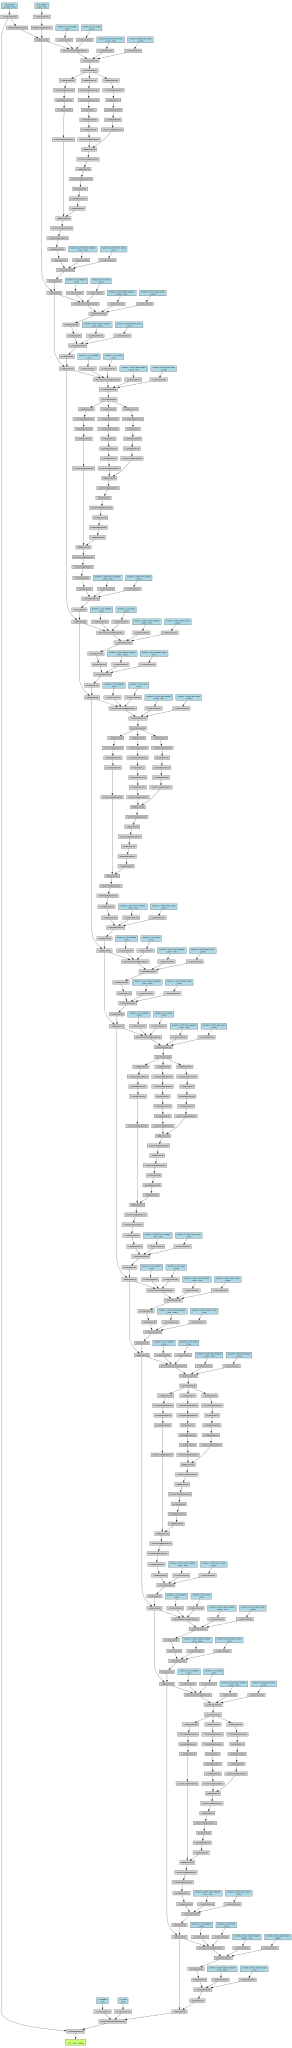

In [6]:
# Visualize the model graph only in interactive notebooks.
try:
    from IPython import get_ipython
    is_notebook = get_ipython() is not None and "IPKernelApp" in get_ipython().config
except Exception:
    is_notebook = False

if is_notebook:
    from torchviz import make_dot

    vocab_size = tokenizer.get_vocab_size()
    viz_batch_size = min(config.BATCH_SIZE, 2)
    viz_context_len = min(config.CONTEXT_LEN, 16)
    x = torch.randint(
        0,
        vocab_size,
        (viz_batch_size, viz_context_len),
        device=device,
        dtype=torch.long,
    )
    y = model(x)

    make_dot(y, params=dict(model.named_parameters()))

## Load the Training Data

In [6]:
from datasets.utils.logging import enable_progress_bar, set_verbosity_error
from loader import (
    TokenEstimator,
    build_interleaved_dataset,
    build_packed_dataset,
    cap_streaming_rows,
    load_dataset_from_spec,
    parse_dataset_specs,
    resolve_resume_plan,
    resolve_total_rows,
    dataset_label,
)
from resume import build_resume_state, cap_resume_rows, is_resume_exhausted, normalize_resume_rows
import math

# Download shards on demand and shuffle within each dataset.
set_verbosity_error()
enable_progress_bar()

# Cache dataset specs for reuse across steps.
dataset_specs = parse_dataset_specs(config.DATASET_SPECS)


# Track total rows per dataset for resume validation.
total_rows_by_spec = {}
avg_tokens_by_spec = {}
est_tokens_by_spec = {}
estimated_total_tokens = 0

print("Datasets:") if is_master else None
for dataset_index, spec in enumerate(dataset_specs):
    raw_dataset = load_dataset_from_spec(
        spec,
        cache_dir=data_dir,
        streaming=True,
    )
    total_rows = resolve_total_rows(raw_dataset, spec, cache_dir=data_dir)
    total_rows_by_spec[spec["spec"]] = total_rows
    if total_rows is None:
        raise ValueError("Dataset split metadata missing num_examples for token estimate.")
    token_estimator = TokenEstimator(
        tokenizer,
        text_key=spec["text_key"],
    )
    avg_tokens, est_total_tokens = token_estimator.estimate_streaming(raw_dataset, total_rows)
    avg_tokens_by_spec[spec["spec"]] = avg_tokens
    est_tokens_by_spec[spec["spec"]] = est_total_tokens
    estimated_total_tokens += est_total_tokens
    print(f"  {dataset_label(spec)}: avg_tokens={avg_tokens:.1f}, est_tokens={est_total_tokens}") if is_master else None

# Resolve model size for token budgeting.
param_count, _ = config.model_info(model)

# Derive the token cap and epoch count from the configured max-training factor.
max_tokens = int(param_count * config.MAX_TRAINING_FACTOR) if config.MAX_TRAINING_FACTOR > 0 else 0
target_tokens = max_tokens or estimated_total_tokens
target_epochs = 1
if max_tokens and estimated_total_tokens > 0:
    target_epochs = max(1, math.ceil(target_tokens / estimated_total_tokens))
tokens_per_step = config.MACRO_BATCH_SIZE * (config.CONTEXT_LEN - 1)
dataset_steps = math.ceil(estimated_total_tokens / tokens_per_step)
if is_master:
    print(f"  Dataset estimate: steps={dataset_steps:,} tokens={estimated_total_tokens:,} tokens_per_step={tokens_per_step:,}")
    print(f"  Target: epochs={target_epochs:,} target_tokens={target_tokens:,} (factor {config.MAX_TRAINING_FACTOR} of model size {param_count:,})")

## Progress and Plotting

## Load the previous Checkpoint

In [ ]:
from plot import Plotter, plot_with_completion
from progress import ProgressLogger
from ddp_debug import build_rng_tensor, log_ddp_debug
from sync import all_gather, all_reduce, flag_broadcast, flag_reduce, sync
from input import make_input_poller
from loader import time_until_first_batch
from checkpointer import Checkpointer
from scheduler import build_warmup_cosine_tokens
from torch.utils.data import DataLoader
import itertools
import os
import signal
import time
# Set up optimizer, learning-rate scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
scheduler = build_warmup_cosine_tokens(optimizer, target_tokens, config.WARMUP_PCT)
lossFn = torch.nn.CrossEntropyLoss(ignore_index=pad_id)
checkpointer = Checkpointer(checkpoint_dir, model, optimizer, scheduler, device=device)

# Load the latest checkpoint if available.
resume_epoch, resume_step, global_step, resume_sample_index, resume_tokens, resume_state = checkpointer.load_latest(is_master=is_master)
resume_info = checkpointer.last_resume_info

# Align the scheduler with the resumed token count.
if resume_tokens:
    scheduler.last_epoch = resume_tokens # we misuse token's epoch count for tokens
    for group, base_lr, lr_lambda in zip(optimizer.param_groups, scheduler.base_lrs, scheduler.lr_lambdas):
        group["lr"] = base_lr * lr_lambda(resume_tokens)

# Report resume state after aligning scheduler tokens.
if is_master and resume_info:
    lr_after = optimizer.param_groups[0]["lr"]
    display_epoch = max(resume_epoch + 1, 1)
    print(
        f"  Checkpoint: loaded epoch={display_epoch} step={resume_step} "
        f"sample={resume_sample_index}",
        flush=True,
    )
    print(
        f"  Optimizer: {resume_info['optimizer']}",
        flush=True,
    )
    print(
        f"  Scheduler: {resume_info['scheduler']} lr={lr_after:.8f}",
        flush=True,
    )

# Normalize resume state into per-spec row offsets.
# Keep offsets from the checkpoint, even for specs not active in this run.
# Ensure current specs always have a default offset for safe lookups.
# This drives shard/row skipping during resume and checkpointing.
resume_rows = normalize_resume_rows(resume_state, dataset_specs)
resume_rows = cap_resume_rows(resume_rows, total_rows_by_spec)

# Cap resume offsets to the known total rows to avoid invalid states.
for spec in dataset_specs:
    spec_key = spec["spec"]
    row_offset = resume_rows.get(spec_key, 0)
    total_rows = total_rows_by_spec.get(spec_key)
    if total_rows is not None and row_offset > total_rows:
        if is_master:
            print(
                f"Clamping resume rows for {spec_key}: {row_offset} -> {total_rows}",
                flush=True,
            )
        resume_rows[spec_key] = total_rows

# Track per-rank row counts for shard-aware resume.
source_row_counts = {spec["spec"]: 0 for spec in dataset_specs}

# Pre-warm dataset shards on the master to avoid DDP startup stalls.
if ddp_enabled:
    if is_master:
        print("Warming dataset cache...", flush=True)
        for spec in dataset_specs:
            warm_dataset = load_dataset_from_spec(
                spec,
                cache_dir=data_dir,
                streaming=True,
            )
            try:
                next(iter(warm_dataset.take(1)))
            except StopIteration:
                pass
    dist.barrier()
# Build packed datasets per source with row-offset resumes.
# Resolve shard-aware resume plans, then stream from the right shard/offset.
# Pack each source into fixed-length token blocks with source IDs.
# Interleave happens later, so each dataset is prepared independently.
# Row offsets are tracked for checkpoint-safe restarts.
packed_datasets = []
for dataset_index, spec in enumerate(dataset_specs):
    spec_key = spec["spec"]
    row_offset = resume_rows.get(spec_key, 0)

    # Skip datasets that are already fully consumed by resume offsets.
    total_rows = total_rows_by_spec.get(spec_key)
    if is_resume_exhausted(row_offset, total_rows):
        print(f"Skipping exhausted dataset {spec_key}: row_offset {row_offset} >= total_rows {total_rows}") if is_master else None
        continue
    data_files, in_shard_offset, shard_label = resolve_resume_plan(
        spec,
        row_offset,
        cache_dir=data_dir,
    )
    raw_streaming = load_dataset_from_spec(
        spec,
        cache_dir=data_dir,
        streaming=True,
        data_files=data_files,
    )

    # Apply shard-local resume offset before splitting.
    if data_files is not None and in_shard_offset > 0:
        raw_streaming = raw_streaming.skip(in_shard_offset)
    if row_offset > 0:
        if data_files is None:
            print(f"  {spec_key}: row={row_offset}", flush=True) if is_master else None
            raw_streaming = raw_streaming.skip(row_offset)
        else:
            print(f"  {spec_key}: shard={shard_label} row={in_shard_offset}", flush=True) if is_master else None

    # Cap each dataset to its remaining rows so exhausted specs stop contributing.
    remaining_rows = None
    if total_rows is not None:
        remaining_rows = max(total_rows - row_offset, 0)
    raw_streaming = cap_streaming_rows(raw_streaming, remaining_rows)
    if ddp_enabled:
        # Split the stream across ranks to avoid duplicate samples.
        raw_streaming = raw_streaming.filter(
            lambda _, idx: idx % ddp_world_size == ddp_rank,
            with_indices=True,
        )
    packed = build_packed_dataset(
        raw_streaming,
        tokenizer=tokenizer,
        block_size=config.CONTEXT_LEN,
        text_key=spec["text_key"],
        pack_batch_size=config.PACK_BATCH_SIZE,
        source_id=dataset_index,
    )
    packed_datasets.append(packed)
if not packed_datasets:
    raise ValueError("All datasets exhausted after resume; check DATASET_SPECS.")

base_dataset = build_interleaved_dataset(packed_datasets, seed=42)
if is_master:
    print(f"Packed dataset ready ({len(packed_datasets)} sources).", flush=True)



## Run the Training

### MacroStep

Tracks macro-step counters, timings, and accumulation state.

In [ ]:
@dataclass
class MacroStep:
    """Track macro-step state across gradient accumulation.
    Owns micro-step counters and timing totals.
    Resets accumulators at macro boundaries.
    Tracks accumulated IO/compute time per macro step.
    """
    micro_steps: int
    current_micro_step: int = 0
    micro_token_total: int = 0
    micro_sample_total: int = 0
    micro_loss_total: float = 0.0
    io_wait: float = 0.0
    compute_time: float = 0.0
    sync_wait: float = 0.0

    def begin(self, optimizer):
        self.compute_time = 0.0
        self.io_wait = 0.0
        self.sync_wait = 0.0
        optimizer.zero_grad()
        self.micro_loss_total = 0.0
        self.micro_token_total = 0
        self.micro_sample_total = 0


    # Return True only for the final micro step in the macro batch.
    def micro_step(self, token_count, sample_count, loss_value):
        self.micro_token_total += token_count
        self.micro_sample_total += sample_count
        self.micro_loss_total += loss_value
        if self.current_micro_step != self.micro_steps - 1:
            self.current_micro_step += 1
            return False
        return True

    @contextlib.contextmanager
    def measure_compute(self):
        start = time.time()
        try:
            yield
        finally:
            self.compute_time += time.time() - start

    @contextlib.contextmanager
    def measure_sync(self):
        start = time.time()
        try:
            yield
        finally:
            self.sync_wait += time.time() - start

    def measure_io(self, loader):
        prev = time.time()
        for batch in loader:
            now = time.time()
            self.io_wait += now - prev
            yield batch
            prev = time.time()

    def finish(self):
        self.io_wait = 0.0
        self.sync_wait = 0.0
        self.current_micro_step = 0

### Synced Payloads

Declarative sync payloads for reductions, gathers, and broadcasts.

In [ ]:
@dataclass
class Synced:
    """Aggregate synced scalars for per-step logging.
    Groups reductions by op to keep the sync block small.
    Uses float fields to match collective expectations.
    """
    average_loss: float = all_reduce("sum")
    loss_min: float = all_reduce("min")
    loss_max: float = all_reduce("max")
    token_count: int = all_reduce("sum", dtype="i64")
    sample_count: int = all_reduce("sum", dtype="i64")
    stop_flag: bool = flag_reduce("max")
    io_wait: float = all_reduce("max")
    compute_time: float = all_reduce("max")
    sync_wait: float = all_reduce("max")
    counts: list = all_reduce("sum", dtype="i64")
    print_input: bool = flag_broadcast(src=0)
    should_checkpoint: bool = flag_broadcast(src=0)


@dataclass
class SyncedDebug:
    """Gather per-rank debug stats for DDP parity checks.
    Bundles loss, batch stats, and RNG fingerprints.
    Only used when debug output is enabled.
    """
    gathered_losses: float = all_gather(dtype="f32")
    stats_gathered: list = all_gather(dtype="i64")
    rng_gathered: list = all_gather(dtype="u64")

### The actual training loop

In [ ]:
# Emit a first-batch timing log while streaming batches.
last_ckpt_time = time.time()
macro_step = MacroStep(
    micro_steps=(config.MACRO_BATCH_SIZE // ddp_world_size) // config.BATCH_SIZE,
)

# Track current counters for checkpointing and interrupts.
current_epoch = resume_epoch
current_step = resume_step
current_sample_index = 0

# Initialize the progress logger to display training progress and loss
progress = ProgressLogger(
    start_global_step=global_step,
    start_total_samples=0,
    start_total_tokens=resume_tokens,
    estimated_total_tokens=target_tokens,
)
plotter = Plotter(
    lambda points: plot_with_completion(points, model, tokenizer, config, device),
    warmup_plot_interval=config.PLOT_WARMUP_SECS,
    plot_interval=config.PLOT_INTERVAL_SECS,
    warmup_window_secs=config.WARMUP_WINDOW_SECS,
)

# Enable debug output with DEBUG levels.
debug_level = int(os.getenv("DEBUG", "0"))
printed_debug_sample = False

# Track SIGINT so we can checkpoint after a safe step.
stop_requested = False
plot_requested = make_input_poller(is_master)
def _request_stop(signum, frame):
    # Record interrupt without raising inside the signal handler.
    print("Interrupted: saving checkpoint...") if is_master else None
    global stop_requested
    stop_requested = True
signal.signal(signal.SIGINT, _request_stop)

print("Starting training loop...", flush=True) if is_master else None
for current_epoch in itertools.count(resume_epoch):
    is_resume_epoch = current_epoch == resume_epoch
    # Reset row counters at epoch boundaries beyond the resume epoch.
    if current_epoch != resume_epoch:
        for spec in dataset_specs:
            source_row_counts[spec["spec"]] = 0
    dataset_epoch = base_dataset.shuffle(buffer_size=config.SHUFFLE_BUFFER, seed=42 + current_epoch).with_format("torch")
    loader = DataLoader(
        dataset_epoch,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.DATA_LOADER_WORKERS,
    )

    # Announce first-batch wait to avoid silent startup stalls.
    for current_step, batch in enumerate(macro_step.measure_io(time_until_first_batch(loader, is_master))):
        # Reset macro-step accumulators and track data wait time.
        if macro_step.current_micro_step == 0:
            macro_step.begin(optimizer)

        # Move batch tensors to the device and prepare an optional attention mask.
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        attn_mask = None
        if attention_mask is not None and not attention_mask.all():
            attn_mask = attention_mask[:, :-1].to(device)
            
        # Build next-token prediction pairs.
        inputs = input_ids[:, :-1].to(device) # everything from the first token except the last
        targets = input_ids[:, 1:].to(device) # everything from the second token onward

        # Preview tokenization outputs for debugging.
        if debug_level >= 2 and not printed_debug_sample and is_master:
            input_preview = inputs[0].tolist()
            target_preview = targets[0].tolist()
            print(f"Input tokens: {input_preview}")
            print(f"Target tokens: {target_preview}")
            print(f"Input text: {tokenizer.decode(input_preview)}")
            print(f"Target text: {tokenizer.decode(target_preview)}")
            printed_debug_sample = True

        # Run the forward pass with autocast and compute loss.
        with macro_step.measure_compute():
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16) if device.type == "cuda" else contextlib.nullcontext():
                logits = model(inputs, attention_mask=attn_mask)
                loss = lossFn(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
                loss /= macro_step.micro_steps # to make macro_step.micro_loss_total equal average loss over the macro batch
                # Avoid all-reduce on accumulation steps.
            with model.no_sync() if ddp_enabled and macro_step.current_micro_step != macro_step.micro_steps - 1 else contextlib.nullcontext():
                loss.backward()

            # Micro step bookkeeping.
            token_count = attention_mask[:, 1:].sum().item()

            # Advance per-source row counters for resume safety.
            row_counts = batch["row_count"].tolist()
            source_ids = batch["source_id"].tolist()
            for source_id, row_count in zip(source_ids, row_counts):
                if row_count:
                    spec_key = dataset_specs[int(source_id)]["spec"]
                    source_row_counts[spec_key] += int(row_count)

            # Update checkpoint counters and save when needed.
            current_sample_index += input_ids.size(0)
            if not macro_step.micro_step(token_count, input_ids.size(0), loss.item()):
                continue

        # Check for on-demand plot requests from stdin.
        input_requested = False
        if (cmd := plot_requested()) == "p":
            plotter.request_plot()
        elif cmd == "i":
            input_requested = True

        # Average the micro loss across ranks for consistent logging.
        # Sync per-spec row counts across ranks for plotting and resume logs.
        spec_keys = [spec["spec"] for spec in dataset_specs]
        now = time.time()
        ckpt_interval = config.CHECKPOINT_WARMUP_SECS if (now - last_ckpt_time) < config.WARMUP_WINDOW_SECS else config.CHECKPOINT_INTERVAL_SECS
        synced = Synced(
            average_loss=macro_step.micro_loss_total / (ddp_world_size if ddp_enabled else 1),
            loss_min=macro_step.micro_loss_total,
            loss_max=macro_step.micro_loss_total,
            token_count=macro_step.micro_token_total,
            sample_count=macro_step.micro_sample_total,
            stop_flag=stop_requested,
            io_wait=macro_step.io_wait,
            compute_time=macro_step.compute_time,
            sync_wait=macro_step.sync_wait,
            counts=[source_row_counts.get(spec_key, 0) for spec_key in spec_keys],
            print_input=(is_master and input_requested),
            should_checkpoint=(now - last_ckpt_time >= ckpt_interval) if is_master else False,
        )
        debug = SyncedDebug(
            gathered_losses=macro_step.micro_loss_total,
            stats_gathered=[macro_step.micro_token_total, macro_step.micro_sample_total],
            rng_gathered=build_rng_tensor(device),
        )
        with macro_step.measure_sync() if ddp_enabled else contextlib.nullcontext():
            synced = sync(synced, device, ddp_enabled=ddp_enabled)
            debug = sync(debug, device, ddp_enabled=ddp_enabled)

        next_total_tokens = progress.total_tokens + synced.token_count
        global_counts = {key: int(value) for key, value in zip(spec_keys, synced.counts)}

        # Update timing output for plot logs.
        io_wait_max = macro_step.io_wait
        compute_max = macro_step.compute_time
        sync_wait_max = macro_step.sync_wait
        if ddp_enabled:
            io_wait_max = synced.io_wait
            compute_max = synced.compute_time
            sync_wait_max = synced.sync_wait

        # Log macro step counts while keeping micro-step checkpointing intact.
        plot_printed = False
        if is_master:
            progress.tick(
                synced.average_loss,
                loss_delta=(synced.loss_max - synced.loss_min if ddp_enabled else None),
                batch_size=macro_step.micro_sample_total,
                token_count=synced.token_count,
                lr=optimizer.param_groups[0]["lr"],
                epoch=current_epoch,
                step=current_step // macro_step.micro_steps,
                remaining_tokens=max(target_tokens - next_total_tokens, 0),
                io_time=io_wait_max,
                gpu_time=compute_max,
                sync_time=sync_wait_max,
            )
        plot_printed = plotter.tick(
            synced.token_count,
            synced.average_loss,
            is_master=is_master,
        )
        if ddp_enabled and plot_printed and is_master:
            log_ddp_debug(debug.gathered_losses, debug.stats_gathered, debug.rng_gathered, is_master)

        if plot_printed and is_master:
            plotter.print_dataset_pos(
                total_tokens=progress.total_tokens,
                global_counts=global_counts,
                resume_base=resume_rows if is_resume_epoch else {},
                dataset_specs=dataset_specs,
                total_rows_by_spec=total_rows_by_spec,
                avg_tokens_by_spec=avg_tokens_by_spec,
                est_tokens_by_spec=est_tokens_by_spec,
                target_tokens=target_tokens,
            )

        # Emit a per-rank input sample for shard sanity checks.
        if debug_level >= 1 or synced.print_input:
            progress.print_input_sample(
                ddp_rank,
                inputs,
                attention_mask,
                tokenizer,
                source_ids=batch.get("source_id"),
                dataset_specs=dataset_specs,
            )

        # Apply gradient clipping.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Apply the optimizer step.
        optimizer.step()

        # Apply the optimizer step and advance the token scheduler.
        scheduler.last_epoch = next_total_tokens - 1
        scheduler.step()

        macro_step.finish()
        now = time.time()

        # Determine if we should checkpoint at this step.
        if synced.should_checkpoint or synced.stop_flag:
            # Build the resume state for the checkpoint.
            combined_counts = dict(resume_rows if is_resume_epoch else {})
            for spec in dataset_specs:
                spec_key = spec["spec"]
                combined_counts[spec_key] = combined_counts.get(spec_key, 0) + source_row_counts.get(spec_key, 0)
            resume_state = build_resume_state(combined_counts, dataset_specs)

            # Aggregate per-rank row counts for global resume offsets.
            if ddp_enabled:
                spec_keys = [spec["spec"] for spec in dataset_specs]
                counts_tensor = torch.tensor(
                    [source_row_counts.get(spec_key, 0) for spec_key in spec_keys],
                    dtype=torch.long,
                    device=device,
                )
                dist.all_reduce(counts_tensor, op=dist.ReduceOp.SUM)
                if is_master:
                    global_counts = dict(resume_rows if is_resume_epoch else {})
                    for spec_key, value in zip(spec_keys, counts_tensor.tolist()):
                        global_counts[spec_key] = global_counts.get(spec_key, 0) + int(value)
                    resume_state = build_resume_state(global_counts, dataset_specs)

            # Persist checkpoints only from the master process.
            if is_master:
                checkpointer.save_latest(
                    current_epoch,
                    current_step,
                    progress.global_step,
                    current_sample_index,
                    progress.total_tokens,
                    resume_state=resume_state,
                )
            if ddp_enabled:
                dist.barrier()
            last_ckpt_time = now

        # Exit after the current step if SIGINT was requested.
        if synced.stop_flag:
            break

    else:
        # Reset the sample index after a full epoch without interruption.
        current_sample_index = 0
        continue

    # Stop training after an interrupted epoch.
    break

# Clean up the process group after training completes.
if ddp_enabled:
    dist.destroy_process_group()

Resuming from /Users/sts/Quellen/nanoschnack/checkpoints/latest.pt at epoch 0, step 98.
Epoch 1 (Step 100, Global 100), Loss: 6.3413, Samples/s: 5.2
